# Analysis of dumps
## Raw Data
The test suite stores tcpdump output in a json format. Because this contains information about each packet, it can be parsed to determine information that would not normally be revealed by the transfer program itself. For example, how much overhead or compression there was.

In [1]:
from helpers import get_dump_fnames, get_dumps, organize_dumps

PROTOCOLS = ["scp", "hpn-scp", "ftp", "gridftp"]
N = None # The number of records to retrieve (None=all)

# Find the relevant dumps
names = get_dump_fnames(PROTOCOLS, N)
dumps = get_dumps(names)

# Fetch relevant columns and rename them
df, ids = organize_dumps(dumps)

In [2]:
df

,Protocol,Batch ID,Stored Packets,Start Time,File Size (bytes),Bytes Down,Bytes Up,Bytes Total,Ratio (%),Time (s),Speed (bytes/s)
0,ftp,128,False,2015-10-15 14:07:40,536870912,537872041,1281883,539153924,100.43,21.92,24537958.07
1,ftp,199,False,2015-10-15 14:25:43,536870912,537945577,1288499,539234076,100.44,18.78,28644599.41
2,ftp,108,False,2015-10-15 14:43:50,536870912,537960153,1296611,539256764,100.44,21.76,24722433.50
3,ftp,82,False,2015-10-15 15:01:49,536870912,529905737,1264963,531170700,98.94,23.95,22125500.50
4,ftp,164,False,2015-10-15 15:20:06,536870912,538010953,1273667,539284620,100.45,24.31,22131260.92
5,ftp,154,False,2015-10-16 01:00:20,536870912,537795545,1315803,539111348,100.42,24.38,22058882.08
6,ftp,8,False,2015-10-16 01:18:38,536870912,538108265,1312227,539420492,100.47,23.23,23164367.84
7,ftp,161,False,2015-10-16 01:36:51,536870912,538005257,1284003,539289260,100.45,23.68,22719816.60
8,ftp,144,False,2015-10-16 01:54:58,536870912,538055385,1284067,539339452,100.46,22.53,23881730.36
9,ftp,183,False,2015-10-16 02:13:13,536870912,537805425,1289699,539095124,100.41,22.28,24138484.07


## Remove outliers
The data doesn't tend to have outliers for large filesizes, but with file less than 10Mb there can be some anomalies

In [3]:
sel = df[df["File Size (bytes)"] < 10000000] # Choose everything less than 10Mb
# If the ratio of filesize to packets is more than 1 million, there is a problem
outliers = sel[sel["Bytes Total"]/sel["File Size (bytes)"] > 1000000]

# Remove only those lines. For now, leave the rest of the batch
df.drop(outliers.index, inplace=True)

print "Removed %s entries" % len(outliers)

Removed 0 entries


## Aggregate Data
The table above can be aggregated per filesize and protocol, then displayed visually.

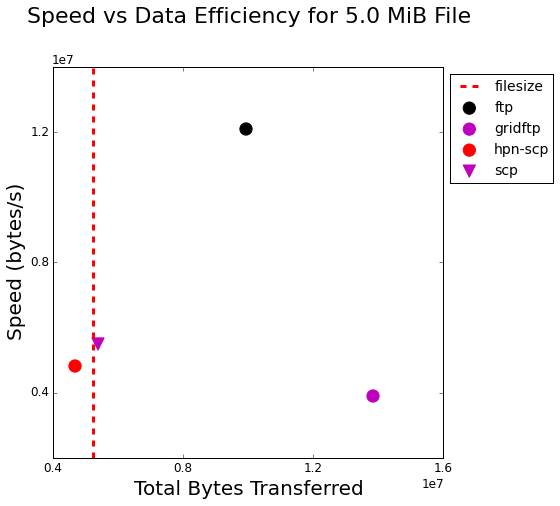

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt, rcParams
from ipywidgets import interact, fixed
import numpy as np
import pandas as pd

from plot import plot_speed_efficiency
from helpers import sizeof_fmt

LABEL_SIZE = 12

rcParams['figure.figsize'] = (7, 7)
rcParams['xtick.labelsize'] = LABEL_SIZE
rcParams['ytick.labelsize'] = LABEL_SIZE

# Group by Filesize and then Protocol
agg = df.groupby(["File Size (bytes)", "Protocol"]).aggregate(np.mean)
agg.drop(["Batch ID", "Stored Packets"], axis=1, inplace=True)

sizes = {str(sizeof_fmt(x)):x for x in set(df["File Size (bytes)"])}
agg_interact = interact(plot_speed_efficiency, df=fixed(agg), filesize=sizes)

In [5]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

# print agg.reset_index().to_latex()
agg

Bytes Down  Bytes Up  Bytes Total  Ratio (%)  \
File Size (bytes) Protocol                                                  
5242880           ftp         9922928.4   14540.1    9937468.5      189.5   
                  gridftp     5080052.9 8774708.2   13854761.0      264.3   
                  hpn-scp     4666512.3    6496.9    4673009.1       89.1   
                  scp         5224851.0  160461.1    5385312.1      102.7   
536870912         ftp       537007757.3 1291980.4  538299737.7      100.3   
                  gridftp   534573783.6    4429.3  534578212.9       99.6   
                  hpn-scp   537171422.0  166915.8  537338337.8      100.1   
                  scp       534104526.3  188454.4  534292980.7       99.5   
1073741824        ftp      1073357571.6 2553835.6 1075911407.2      100.2   
                  gridftp  1073079145.8    4428.0 1073083573.8       99.9   
                  hpn-scp  1071535742.8  342785.1 1071878527.9       99.8   
                  scp      1074336336.4  382952.0 1074719288.4      100.1   
1610612736        ftp      1612216037.3 3828633.2 1616044670.5      100.3   
                  gridftp  1609088422.9    4426.1 1609092849.0       99.9   
                  hpn-scp  1610127154.9  511912.7 1610639067.7      100.0   
                  scp      1608744654.9  577390.4 1609322045.4       99.9   
2147479552        ftp      2148673854.9 5075559.6 2153749414.5      100.3   
                  gridftp  2147364435.1    4429.3 2147368864.3      100.0   
                  hpn-scp  2147870110.0  694075.5 2148564185.5      100.1   
                  scp      2149719545.9  774732.1 2150494278.1      100.1   
2540610608        ftp      2545393837.5 5996149.6 2551389987.0      100.4   
                  gridftp  2536383335.4    4406.8 2536387742.2       99.8   
                  hpn-scp  2531341159.6  792915.0 2532134074.6       99.7   
                  scp      2534857393.3  913497.4 2535770890.7       99.8   

                            Time (s)  Speed (bytes/s)  
File Size (bytes) Protocol                             
5242880           ftp            1.4       12094979.9  
                  gridftp        1.3        3886209.6  
                  hpn-scp        1.0        4829022.0  
                  scp            1.0        5506684.1  
536870912         ftp           23.3       23161405.3  
                  gridftp       24.5       21980615.4  
                  hpn-scp       23.6       22923730.8  
                  scp           23.1       23189047.2  
1073741824        ftp           46.6       23139968.4  
                  gridftp       47.9       22472118.5  
                  hpn-scp       46.2       23227507.5  
                  scp           45.4       23704931.9  
1610612736        ftp           69.3       23295999.1  
                  gridftp       70.9       22740693.2  
                  hpn-scp       69.4       23229536.9  
                  scp           68.5       23490043.3  
2147479552        ftp           91.1       23604911.2  
                  gridftp       95.7       22444177.1  
                  hpn-scp       92.1       23345011.5  
                  scp           91.1       23620164.9  
2540610608        ftp          107.4       23717061.8  
                  gridftp      114.7       22128903.4  
                  hpn-scp      115.6       22026116.8  
                  scp          108.2       23450202.2

## Metrics per filesize
The above data can also be shown as two separate graphs, as a function of filesize.

## Speed

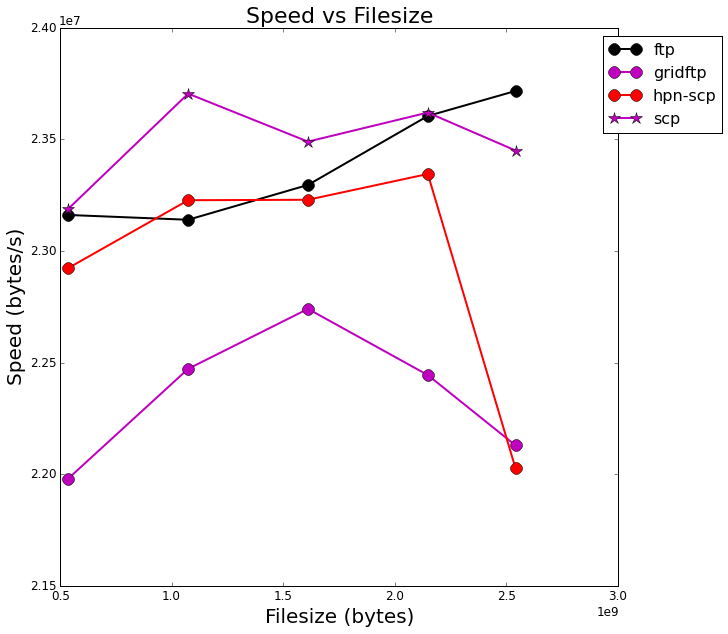

In [6]:
%matplotlib inline
from plot import plot_speed_per_filesize

rcParams['figure.figsize'] = (10, 10)

plot_speed_per_filesize(df, ratio=False, ignore_small=True)

## Data Usage

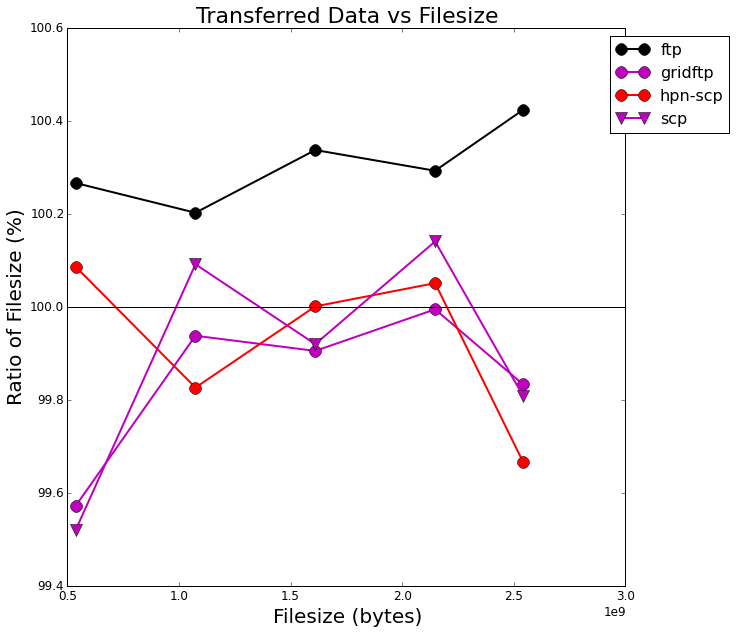

In [7]:
%matplotlib inline
from plot import plot_data_per_filesize

rcParams['figure.figsize'] = (10, 10)

plot_data_per_filesize(df, ignore_small=True)

# Network stability
The network may be busier at certain times. If the tests are run at different hours of the day, this can be explored.

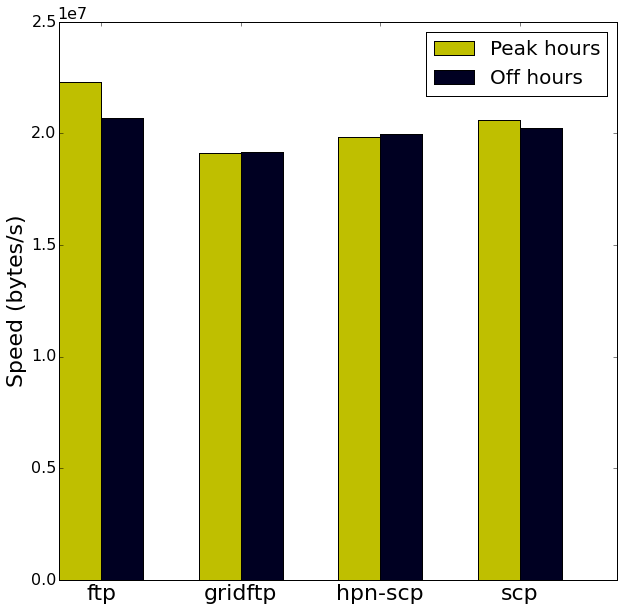

In [15]:
%matplotlib inline
from datetime import time

from plot import plot_speed_day_night

LABEL_SIZE = 16
rcParams['figure.figsize'] = (10, 10)
rcParams['xtick.labelsize'] = LABEL_SIZE
rcParams['ytick.labelsize'] = LABEL_SIZE

# Group the data into working hours and off hours
t1 = time(11, 0 ,0)
t2 = time(15, 0, 0)
is_day = lambda x: t1 <= x.time() <= t2
day = df[[is_day(x) for x in df["Start Time"]]]
night = df[[not is_day(x) for x in df["Start Time"]]]

# Aggregate the frames by protocol, fetch their speed
get_speed = lambda df: df.groupby(["Protocol"]).aggregate(np.mean)["Speed (bytes/s)"] 
speed_day = get_speed(day)
speed_night = get_speed(night)
    
plot_speed_day_night(speed_day, speed_night, title=False)


In [39]:
from scipy import stats
import pandas as pd

print "The null hypothesis is that the samples have identical average (expected) values."
print "A value of None means that the data was not normal"
diff = pd.DataFrame(columns=set(day["Protocol"]))

for p in set(day["Protocol"]):
    a = day[day["Protocol"] == p]["Speed (bytes/s)"]
    b = night[night["Protocol"] == p]["Speed (bytes/s)"]
    if stats.normaltest(a)[1] > 0.05 or stats.normaltest(b)[1] > 0.05:
        diff[p] = [None]
    else:
        diff[p] = [stats.ttest_ind(a, b)[1]]

diff = diff.transpose()
diff.columns = ["p-value"]
diff

The null hypothesis is that the samples have identical average (expected) values.
A value of None means that the data was not normal


,p-value
ftp,0.5
hpn-scp,0.9
gridftp,1.0
scp,0.7


## Topography of Transfer
Displaying the packet sizes against a time axis gives more insight into each protocol. It's also a good representation of network conditions, as breaks or delays are easily seen.

In [ ]:
%matplotlib inline
import warnings

from plot import plot_packets

warnings.simplefilter('ignore', UserWarning)
rcParams['figure.figsize'] = (12, 12)

def reverse_lookup(bid):
    for key, val in ids.items():
        if val == bid:
            return key
    return None

batch_ids = {str(x):reverse_lookup(x) for x in set(df[df["Stored Packets"]]["Batch ID"])}

if batch_ids:
    packet_interact = interact(plot_packets, batch_id=batch_ids)
else:
    print "No batches with stored packets found"
    print "Run test.py with the --store-packets argument"